## Script for calculating metrics on the output of the UNET and traditional models

In [4]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from skimage import metrics
from tqdm import tqdm
import pickle
import seaborn as sns
import scipy.ndimage as ndimage
sns.set_theme(style="darkgrid")

In [5]:
mask = sio.loadmat('mask.mat')['mask']
np.sum(mask)

44241

In [6]:
# with open('Datasets/SpinningOPChangeNoisy/SpinningOPChangeNoisyWithUNETTrainedOnNoNoise.pickle', 'rb') as handle:
#     unserialized_data = pickle.load(handle)
# data = unserialized_data
# unet_trained_on_no_noise = data['HbOvol_unet']
# del data

In [7]:
# with open('Datasets/SpinningOPChangeNoisy/SpinningOPChangeNoisyWithUNETStdNorm.pickle', 'rb') as handle:
#     unserialized_data = pickle.load(handle)
# data = unserialized_data
# unet_std_norm = data['HbOvol_unet']
# del data

In [8]:
with open('Datasets/SpinningOPChangeNoisy/SpinningOPChangeNoisyWithUNETFinal.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

In [9]:
data = unserialized_data

In [10]:
unet_min_max = np.array(data['HbOvol_unet'], dtype=np.float32)
smoothed = data['HbOvol_smoothed']
unsmoothed = data['HbOvol']
locations = data['locations'][:,0,:]


In [11]:
ground_truth = data['ground_truth'][::-1,...]

In [12]:
for i in tqdm(range(ground_truth.shape[-1])):
        smoothed[...,i] = smoothed[::-1,...,i] * mask
        unsmoothed[...,i] = unsmoothed[::-1,...,i] * mask
        #unet_trained_on_no_noise[...,i] = unet_trained_on_no_noise[::-1,...,i] * mask
        unet_min_max[...,i] = unet_min_max[::-1,...,i] * mask * np.max(unsmoothed[...,i])
        #unet_std_norm[...,i] = unet_std_norm[::-1,...,i] * mask

100%|██████████| 756/756 [00:14<00:00, 52.81it/s]


In [13]:
locations = data['locations'][:,0,:]
del data

With ground truth from generation used as the optimal measurement the rest of the metrics are calculated based on that being ground truth

In [14]:
ground_truth.shape

(80, 32, 64, 756)

In [15]:
df = pd.DataFrame(columns=['unet_mse', 'unet_ssim', 'smoothed_mse', 'smoothed_ssim', 'unsmoothed_mse', 'unsmoothed_ssim'])
df

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim


In [16]:
def mse(input, target):
    """
    returns the array of the mean squared error of the input vs target
    :param input: array
    :param target: array
    :return: 
    """
    return np.sum(np.subtract(input, target) ** 2, axis=tuple([0, 1, 2]))

def ssim(input, target):
    """
    return the array of SSIM of the input vs target
    :param input: 
    :param target: 
    :return: 
    """
    ssim = []
    dataRange = np.max([np.max(target),np.max(input)])
    for i in range(input.shape[-1]):
        ssim.append(metrics.structural_similarity(target[:,:,:,i],input[:,:,:,i], data_range=dataRange, use_sample_covariance=False))
    return np.array(ssim)

In [147]:
df['smoothed_mse'] = mse(smoothed, ground_truth) 
df['smoothed_ssim'] = ssim(smoothed, ground_truth)

In [148]:
df['unsmoothed_mse'] = mse(unsmoothed, ground_truth)
df['unsmoothed_ssim'] = ssim(unsmoothed, ground_truth)

In [149]:
df['unet_mse'] = mse(unet_min_max, ground_truth)
df['unet_ssim'] = ssim(unet_min_max, ground_truth)

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   unet_mse         756 non-null    float64
 1   unet_ssim        756 non-null    float64
 2   smoothed_mse     756 non-null    float64
 3   smoothed_ssim    756 non-null    float64
 4   unsmoothed_mse   756 non-null    float64
 5   unsmoothed_ssim  756 non-null    float64
dtypes: float64(6)
memory usage: 35.6 KB


In [151]:
df.head()

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim
0,0.000206,0.988087,0.000529,0.884606,0.001524,0.921673
1,0.001266,0.974928,0.000718,0.882678,0.001786,0.919933
2,0.000840,0.977475,0.000837,0.878258,0.002171,0.915653
3,0.000509,0.981356,0.000768,0.869884,0.002003,0.910662
4,0.000580,0.981496,0.000891,0.869854,0.002245,0.909370


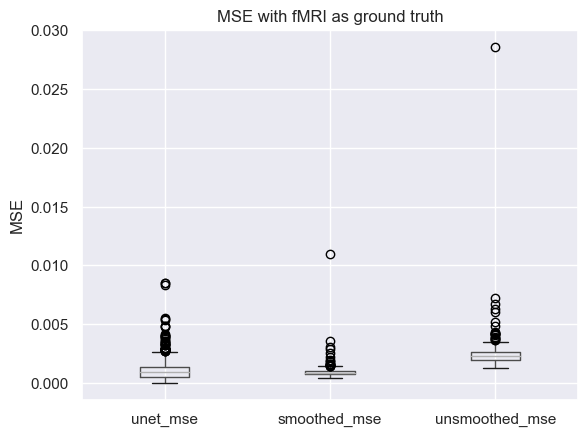

In [152]:
plt.figure()
df.boxplot(column=['unet_mse', 'smoothed_mse', 'unsmoothed_mse'])
plt.ylabel('MSE')
plt.title('MSE with fMRI as ground truth')
plt.show()

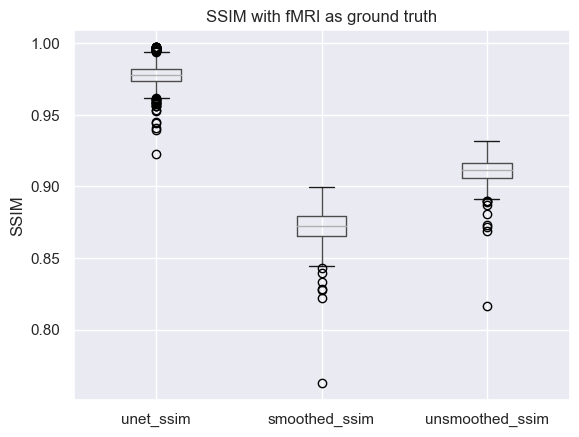

In [153]:
plt.figure()
df.boxplot(column=['unet_ssim', 'smoothed_ssim', 'unsmoothed_ssim'])
plt.ylabel('SSIM')
plt.title('SSIM with fMRI as ground truth')
plt.show()

In [41]:
def plotErrorLine(metric, images_per_OP=36, optical_property_changes=np.arange(0,21), logy=False, legend_pos=None, ylims=None):
    df2 = pd.DataFrame(columns=['OPchange', metric, 'ReconstructionMethod'])
    recon_method = [string for string in df.keys() if string.endswith(metric)]
    for recon in recon_method:
        for [i, x] in enumerate(optical_property_changes):
            df3 = pd.DataFrame({'OPchange' : x*np.ones(images_per_OP), metric : df[recon][i*images_per_OP:images_per_OP*(1+i)], 'ReconstructionMethod' : [recon.split('_')[0]]*images_per_OP})
            df2 = pd.concat([df2, df3])
    # Plot the responses for different events and regions
    sns.lineplot(x="OPchange", y=metric,
                 hue="ReconstructionMethod",
                 data=df2, errorbar='ci')
    if ylims is not None:
        plt.ylim(ylims)
    plt.title(f'{metric} comparison of different methods')
    plt.ylabel(f'{metric} (mm)')
    plt.xlabel('OP Change (%)')
    if legend_pos is None:
        plt.legend()
    else:
        plt.legend(loc=legend_pos)
    if logy:
        plt.semilogy()
    plt.savefig(f'PostprocessingComparison{metric}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    return

In [18]:
plotErrorLine('mse')

ValueError: array length 36 does not match index length 0

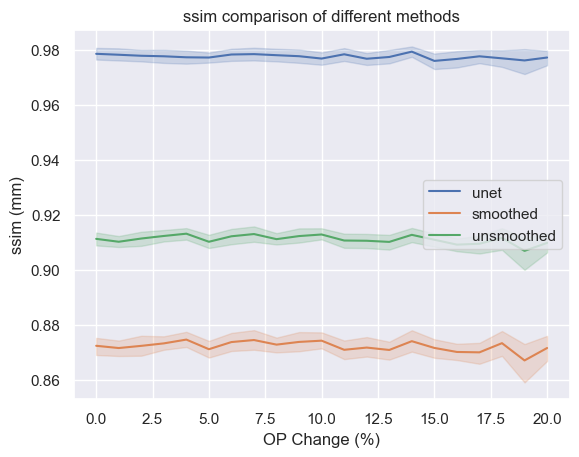

In [156]:
plotErrorLine('ssim')

In [20]:
xgrid = np.arange(-79,81,2)#-79:2:79;
ygrid = np.arange(-119,-59,2)#-119:2:-57;
zgrid = np.arange(-58,70,2)#-58:2:68;


def coordToIndex(coord):
    return np.argwhere(ygrid==coord[1])[0][0], np.argwhere(xgrid==coord[0])[0][0], np.argwhere(zgrid==coord[2])[0][0]


def indexToCoord(index):
    if len(np.array(index).shape) == 2:
        return np.array([-79 + index[:,1]*2,-119 + index[:,1]*2,-58 + index[:,1]*2]).T   
    else:
        return [-79 + index[0]*2,-119 + index[1]*2,-58 + index[2]*2]    


def calculateMask(image, method):
    if method == 'biggest_cluster':
        mask = biggestCluster(image)
    elif method == 'heaviest_cluster':
        mask = heaviestCluster(image)
    else:
        mask = np.ones(image.shape)
    return mask


def biggestCluster(image):
    """
    Returns a mask of the largest cluster in the image
    :param image: 
    :return: 
    """
    image_labelled, max_label = ndimage.label(image)
    biggest_label = None
    biggest_count = 0
    for i in range(1,max_label+1):
        cnt = np.count_nonzero(image_labelled==i)
        if cnt > biggest_count:
            biggest_label = i
            biggest_count = cnt
    clusterMask = image_labelled == biggest_label
    return clusterMask


def heaviestCluster(image):
    image_labelled, max_label = ndimage.label(image)
    biggest_label = None
    biggest_cluster_weight = 0
    for i in range(1,max_label+1):
        cluster_weight = np.sum(np.where(image_labelled==i, image, 0))
        if cluster_weight > biggest_cluster_weight:
            biggest_label = i
            biggest_cluster_weight = cluster_weight
    clusterMask = image_labelled == biggest_label
    return clusterMask


def LOCAscoreWhite(image, target_point, method):
    """
    Distance from the centre of mass of the activation to the target point
    :param image: 
    :param target_point: 
    :return: 
    """
    image_max = np.max(image)
    threshold_image = np.where(image>image_max/2, image, 0)
    cluster_mask =  calculateMask(threshold_image, method)
    ind = ndimage.center_of_mass(threshold_image * cluster_mask)
    localisation_error = np.linalg.norm(np.array(indexToCoord(ind)) - target_point)
    return localisation_error


def LOCAWhite(processed_images, target_points, method=None):
    scores = []
    for i in tqdm(range(processed_images.shape[3])):
        score = LOCAscoreWhite(processed_images[...,i], target_points[:,i], method)
        scores.append(score)
    return scores


def FWHMscorefast(image, method):
    """
    Maximum distance between the two nodes that are more than or equal to 50% of the max reconstruction
    :param image: 
    :return: 
    """
    image_max = np.max(image)
    threshold_mask = image>image_max/2
    threshold_image = np.where(image>image_max/2, image, 0)
    cluster_mask = calculateMask(threshold_image, method)
    idxs = np.argwhere(threshold_mask * cluster_mask)
    big_idxs = np.broadcast_to(idxs, [idxs.shape[0],idxs.shape[0],idxs.shape[1]])
    score = np.max(np.linalg.norm(np.swapaxes(big_idxs, 0, 1) - idxs, axis=2))
    return score * 2 #2mm voxels


def FWHM(processed_images, method=None):
    scores = []
    for i in tqdm(range(processed_images.shape[3])):
        score = FWHMscorefast(processed_images[..., i], method)
        scores.append(score)
    return scores


def ERESscore(image, target_point, method):
    """
    Distance from the target point to the furthest value greater than 50% of the max value
    :param image: 
    :param target_point: 
    :return: 
    """
    image_max = np.max(image)
    threshold_mask = image>image_max/2
    threshold_image = np.where(image>image_max/2, image, 0)
    cluster_mask = calculateMask(threshold_image, method)
    idxs = np.argwhere(threshold_mask * cluster_mask)
    effective_resolution = np.max(np.linalg.norm(indexToCoord(idxs) - target_point, axis=1))
    return effective_resolution


def ERES(processed_images, target_points, method=None):
    scores = []
    for i in tqdm(range(processed_images.shape[3])):
        score = ERESscore(processed_images[...,i], target_points[:,i], method)
        scores.append(score)
    return scores

def contrast_michelson(image):
    I_max = np.max(image)
    I_min = np.min(image)
    return (I_max - I_min) / (I_max + I_min) if (I_max + I_min) != 0 else 0


from skimage.measure import shannon_entropy

def contrast_entropy(image):
    return shannon_entropy(image)


def contrast_std(image):
    return np.std(image)


def contrast(processed_images):
    contrast = []
    for i in tqdm(range(processed_images.shape[3])):
        contrast.append(contrast_michelson(processed_images[:,:,:,i]))
    return contrast


def valueCalc(image, truth, method):
    image_max = np.max(image)
    threshold_mask = image>image_max/2
    threshold_image = np.where(image>image_max/2, image, 0)
    cluster_mask = calculateMask(threshold_image, method)
    avg_val = np.sum(cluster_mask * image)/np.sum(cluster_mask)
    return avg_val/np.max(truth)


def opValues(processed_images, method):
    """
    Doesn't function as expected
    :param processed_images: 
    :param method: 
    :return: 
    """
    values = []
    for i in tqdm(range(processed_images.shape[3])):
        values.append(valueCalc(processed_images[:,:,:,i], ground_truth[:,:,:,i], method))
    return values

## To base the locations off the ground truth rather than the target centre

In [21]:
locations = np.array([indexToCoord(ndimage.center_of_mass(ground_truth[..., i])) for i in range(ground_truth.shape[3])]).T
locations

array([[ 35.0174417 ,  33.54236178,  30.84076648, ...,  32.73170669,
         34.73385212,  37.1568024 ],
       [-88.38441772, -88.94705575, -90.21866588, ..., -94.62202857,
        -92.54141052, -86.88440079],
       [ 20.67259349,  21.82082761,  23.70247674, ...,   6.56606508,
          7.30855248,  15.20163961]])

In [22]:
df['unet_min_max_LOCA'] = LOCAWhite(unet_min_max,locations, method='heaviest_cluster')
#df['unet_trained_on_no_noise_LOCA'] = LOCAWhite(unet_trained_on_no_noise,locations, method='heaviest_cluster')
#df['unet_std_norm_LOCA'] = LOCAWhite(unet_std_norm, locations, method='heaviest_cluster')
df['smoothed_LOCA'] = LOCAWhite(smoothed, locations,  method='heaviest_cluster')
#df['unsmoothed_LOCA'] = LOCAWhite(unsmoothed, locations,  method='heaviest_cluster')
#df['ground_truth_LOCA'] = LOCAWhite(ground_truth, locations,  method='heaviest_cluster')

100%|██████████| 756/756 [00:06<00:00, 117.56it/s]


C:\Users\joeol\AppData\Local\Temp\ipykernel_920\1181482975.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2 = pd.concat([df2, df3])


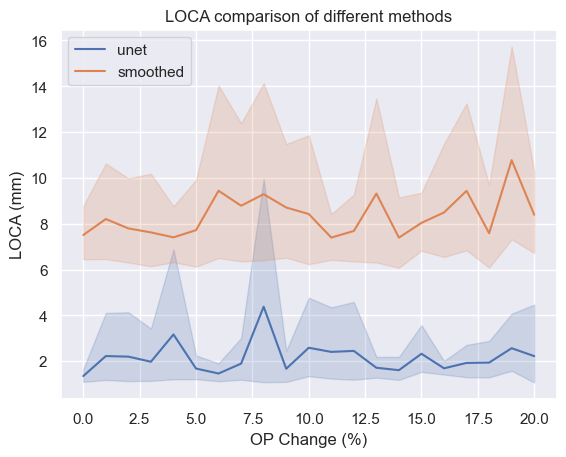

In [23]:
plotErrorLine('LOCA')

In [163]:
df['unet_min_max_FWHM'] = FWHM(unet_min_max, method='heaviest_cluster')
#df['unet_std_norm_FWHM'] = FWHM(unet_std_norm, method='heaviest_cluster')
#df['unet_trained_on_no_noise_FWHM'] = FWHM(unet_trained_on_no_noise, method='heaviest_cluster')
df['smoothed_FWHM'] = FWHM(smoothed, method='heaviest_cluster')
#df['unsmoothed_FWHM'] = FWHM(unsmoothed, method='heaviest_cluster')
#df['ground_truth_FWHM'] = FWHM(ground_truth, method='heaviest_cluster')

100%|██████████| 756/756 [00:06<00:00, 111.70it/s]


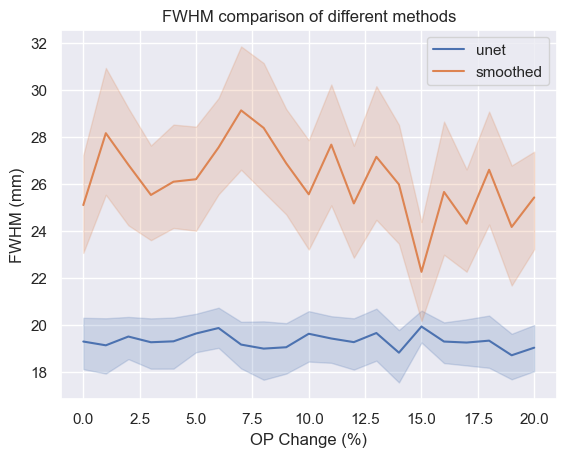

In [164]:
plotErrorLine('FWHM')

In [30]:
df['unet_min_max_Contrast'] = contrast(unet_min_max * (np.max(unsmoothed) - np.min(unsmoothed) + np.min(unsmoothed)))         # (unet_min_max-np.min(unsmoothed))/np.max(unsmoothed))
df['smoothed_Contrast'] = contrast((smoothed))

100%|██████████| 756/756 [00:00<00:00, 5315.76it/s]


C:\Users\joeol\AppData\Local\Temp\ipykernel_920\2405456672.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2 = pd.concat([df2, df3])


     OPchange   Contrast ReconstructionMethod
0         0.0   1.170708                 unet
1         0.0   1.274727                 unet
2         0.0   1.454578                 unet
3         0.0   1.274035                 unet
4         0.0   1.190724                 unet
..        ...        ...                  ...
751      20.0   2.275514             smoothed
752      20.0   2.767751             smoothed
753      20.0   2.296635             smoothed
754      20.0   3.076824             smoothed
755      20.0 -27.368646             smoothed

[1512 rows x 3 columns]


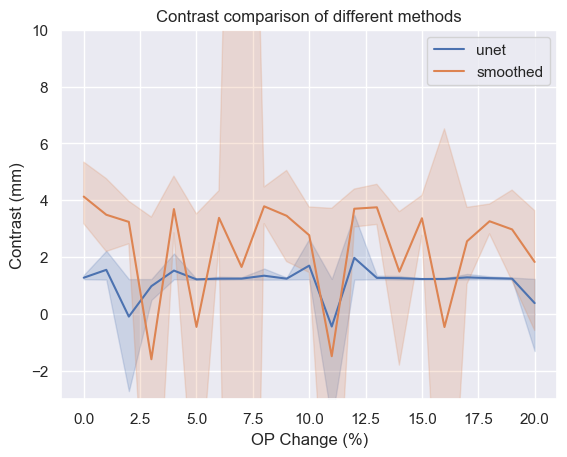

In [42]:
plotErrorLine('Contrast', ylims=[-3,10])

100%|██████████| 756/756 [00:04<00:00, 156.01it/s]


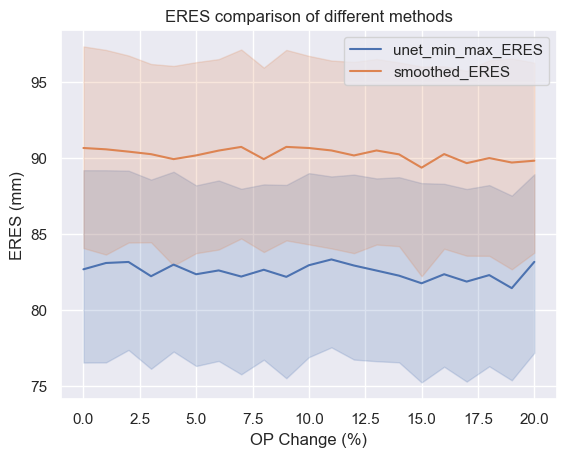

In [64]:
df['unet_min_max_ERES'] = ERES(unet_min_max, locations, method='heaviest_cluster')
#df['unet_std_norm_ERES'] = ERES(unet_std_norm, locations, method='heaviest_cluster')
#df['unet_trained_no_noise_ERES'] = ERES(unet_trained_on_no_noise, locations, method='heaviest_cluster')
df['smoothed_ERES'] = ERES(smoothed, locations, method='heaviest_cluster')
#df['unsmoothed_ERES'] = ERES(unsmoothed, locations, method='heaviest_cluster')
#df['ground_truth_ERES'] = ERES(ground_truth, locations, method='heaviest_cluster')

plotErrorLine('ERES')

In [174]:
df

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim,unet_min_max_LOCA,smoothed_LOCA,unet_min_max_FWHM,smoothed_FWHM,unet_min_max_Contrast,smoothed_Contrast,unet_min_max_OPvalue,smoothed_OPvalue,truth_OPvalue
0,0.000206,0.988087,0.000529,0.884606,0.001524,0.921673,0.534735,6.210889,17.888544,27.495454,0.464284,0.250718,2.562876,1.311478,0.868750
1,0.001266,0.974928,0.000718,0.882678,0.001786,0.919933,1.173162,5.570656,20.976177,23.323808,0.698263,0.293493,4.815238,2.247405,0.894323
2,0.000840,0.977475,0.000837,0.878258,0.002171,0.915653,1.125308,6.044572,20.976177,30.265492,0.726857,0.313940,4.227381,2.185125,0.900740
3,0.000509,0.981356,0.000768,0.869884,0.002003,0.910662,0.848048,5.691423,21.260292,32.557641,0.631559,0.311431,3.713177,1.877995,0.902764
4,0.000580,0.981496,0.000891,0.869854,0.002245,0.909370,1.369077,7.135965,20.493902,26.981475,0.646778,0.344813,4.303727,2.080123,0.906874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.001110,0.974485,0.000781,0.879217,0.002133,0.915516,1.102413,5.011830,18.867962,27.856777,0.817091,0.352872,6.366257,2.511153,0.874830
752,0.001911,0.971352,0.001137,0.858775,0.002943,0.901144,0.982866,4.995219,18.761663,22.360680,0.773216,0.397720,7.366298,2.714473,0.901975
753,0.001059,0.978939,0.001070,0.882010,0.002471,0.916026,0.993462,5.477183,14.696938,22.891046,0.799861,0.381778,6.521716,2.710829,0.899887
754,0.000376,0.985647,0.000638,0.893608,0.001683,0.927802,0.390487,4.341907,16.613248,25.377155,0.575937,0.275250,3.416129,1.606891,0.899128


In [66]:
LOCAscoreWhite(smoothed[::-1,:,:,9], locations[:,9], method='heaviest_cluster')

21.209169839569313

In [67]:
locations

array([[ 35.0174417 ,  33.54236178,  30.84076648, ...,  32.73170669,
         34.73385212,  37.1568024 ],
       [-88.38441772, -88.94705575, -90.21866588, ..., -94.62202857,
        -92.54141052, -86.88440079],
       [ 20.67259349,  21.82082761,  23.70247674, ...,   6.56606508,
          7.30855248,  15.20163961]])

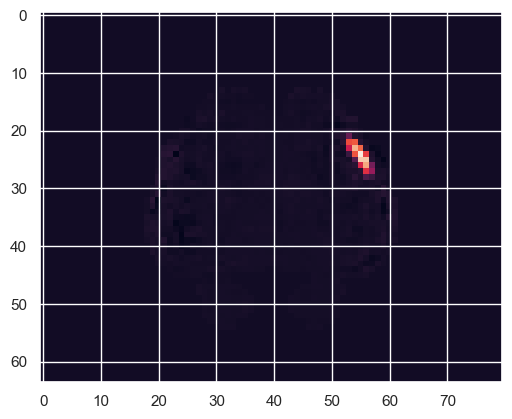

In [68]:
plt.imshow((unet_min_max[:,12,::-1,0]).T)
plt.show()

In [138]:
recon_method = [string for string in df.keys() if string.endswith('LOCA')]
recon_method

['smoothed_LOCA', 'unet_min_max_LOCA']

In [139]:
df

,unet_mse,unet_ssim,smoothed_mse,smoothed_ssim,unsmoothed_mse,unsmoothed_ssim,smoothed_LOCA,unet_min_max_LOCA,unet_min_max_FWHM,smoothed_FWHM,unet_min_max_Contrast,smoothed_Contrast,unet_min_max_ERES,smoothed_ERES
0,NaN,NaN,NaN,NaN,NaN,NaN,6.210889,0.424708,20.493902,27.495454,0.739662,0.250718,105.527239,114.278894
1,NaN,NaN,NaN,NaN,NaN,NaN,5.570656,1.821423,21.633308,23.323808,0.764175,0.293493,107.731227,113.601701
2,NaN,NaN,NaN,NaN,NaN,NaN,6.044572,0.358678,19.899749,30.265492,0.804697,0.313940,106.425432,115.266072
3,NaN,NaN,NaN,NaN,NaN,NaN,5.691423,2.353718,21.633308,32.557641,0.800695,0.311431,104.482014,113.318826
4,NaN,NaN,NaN,NaN,NaN,NaN,7.135965,1.410496,21.908902,26.981475,0.829730,0.344813,105.372973,114.338161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,NaN,NaN,NaN,NaN,NaN,NaN,5.011830,0.390543,18.220867,27.856777,0.763965,0.352872,100.565180,109.006650
752,NaN,NaN,NaN,NaN,NaN,NaN,4.995219,0.338579,20.493902,22.360680,0.841081,0.397720,104.931947,110.617002
753,NaN,NaN,NaN,NaN,NaN,NaN,5.477183,1.793112,16.613248,22.891046,0.776807,0.381778,104.855662,107.672711
754,NaN,NaN,NaN,NaN,NaN,NaN,4.341907,0.360019,19.287302,25.377155,0.749822,0.275250,104.310179,112.847797


In [140]:
df = df.drop('unet_no_noise_LOCA', axis=1)

KeyError: "['unet_no_noise_LOCA'] not found in axis"

In [57]:
unet_std_norm[14,:,9].shape


(32, 756)

In [72]:
unet_std_norm = unet_std_norm.astype(np.float32)
unet_min_max = unet_std_norm.astype(np.float32)
unet_trained_on_no_noise = unet_trained_on_no_noise.astype(np.float32)
smoothed = smoothed.astype(np.float32)
unsmoothed = unsmoothed.astype(np.float32)
ground_truth = ground_truth.astype(np.float32)

In [45]:
np.random.rand() * 10 + 5

9.40649194240016

In [50]:
np.linalg.norm([-3,-5,-12]) 

13.341664064126334